In [ ]:
# Cell 1: Setup and Installs
!pip install sentence-transformers pandas scikit-learn tensorflow matplotlib

import pandas as pd
import numpy as np
import ast # For safely evaluating string representations of Python literals
import io # For reading string CSV data
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Potentially for numerical features if we had more
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("Libraries installed and imported.")

Libraries installed and imported.


In [ ]:
# Cell 2: Load Data from Colab Filesystem
import pandas as pd
import io # Not strictly needed here, but good to have if you were using BytesIO for other reasons

# --- IMPORTANT: Ensure your CSV file is uploaded to Colab's file browser ---
# --- and update the path below if it's not in the root /content/ directory ---
file_path = '/content/English_long_formatted.csv'  # Default path for files uploaded to root

try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded '{file_path}'")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'.")
    print("Please make sure you have uploaded the file to Google Colab's 'Files' panel (usually on the left)")
    print("and that the file_path variable in this cell is correct.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent errors in subsequent cells if file not found

# Proceed only if df is not empty
if not df.empty:
    # Drop the unnamed index column if it exists from the original CSV
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    elif df.columns[0] == '' and len(df.columns) > 1: # Check if the first column is unnamed
        df = df.rename(columns={'': 'original_index'}).drop(columns=['original_index'])

    print("\nDataFrame Head:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
    print(f"\nDataFrame Shape: {df.shape}")
else:
    print("\nDataFrame is empty. Please check the file loading step.")

Successfully loaded '/content/English_long_formatted.csv'

DataFrame Head:
              Scenario_id              Annotator_id  \
0  long_id_0_MJI_Emotions  6600f13d42341b1aae3e20ae   
1  long_id_0_MJI_Emotions  5db31089a1f8d3000c10a6c5   
2  long_id_0_MJI_Emotions  67800f3ec0dbb391ae5e2b35   
3            Reddit_id_50  5db31089a1f8d3000c10a6c5   
4            Reddit_id_50  63dc7c4191d5e30193f1db36   

                                            Scenario  \
0  A manager is considering two candidates for a ...   
1  A manager is considering two candidates for a ...   
2  A manager is considering two candidates for a ...   
3  A person is invited to a close friend's birthd...   
4  A person is invited to a close friend's birthd...   

                                    Possible_actions  Selected_action  \
0  ['Promote the Highly Qualified Candidate, pote...                2   
1  ['Promote the Highly Qualified Candidate, pote...                2   
2  ['Promote the Highly Qualified Cand

In [ ]:
# Cell 3: Data Cleaning and Preprocessing - Parsing Literals

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        return val # Return original if not a valid literal (e.g. already a list, or 'None' string)

# Parse string-represented lists/dictionaries
df['Possible_actions'] = df['Possible_actions'].apply(safe_literal_eval)
df['Contributing_factors'] = df['Contributing_factors'].apply(safe_literal_eval)
df['Contributing_emotion'] = df['Contributing_emotion'].apply(safe_literal_eval)

# Parse Moral_values and expand into separate columns
moral_values_parsed = df['Moral_values'].apply(safe_literal_eval)
moral_values_df = pd.json_normalize(moral_values_parsed) # Flattens the dict

# Define the order of moral value columns (target variables)
moral_value_cols = ['Care', 'Equality', 'Proportionality', 'Loyalty', 'Authority', 'Purity']
for col in moral_value_cols:
    if col not in moral_values_df.columns:
         moral_values_df[col] = np.nan # Add missing columns if any, though unlikely here

df = pd.concat([df, moral_values_df[moral_value_cols]], axis=1)

print("DataFrame Head after parsing literals and expanding moral values:")
print(df[['Scenario_id', 'Possible_actions', 'Contributing_emotion', 'Care', 'Loyalty']].head()) # Show a subset of columns
df.info()

DataFrame Head after parsing literals and expanding moral values:
              Scenario_id                                   Possible_actions  \
0  long_id_0_MJI_Emotions  [Promote the Highly Qualified Candidate, poten...   
1  long_id_0_MJI_Emotions  [Promote the Highly Qualified Candidate, poten...   
2  long_id_0_MJI_Emotions  [Promote the Highly Qualified Candidate, poten...   
3            Reddit_id_50  [Attend the party to maintain the friendship a...   
4            Reddit_id_50  [Attend the party to maintain the friendship a...   

         Contributing_emotion  Care  Loyalty  
0                     [Trust]  3.83     3.50  
1              [Anticipation]  4.67     2.33  
2  [Joy, Trust, Anticipation]  4.00     2.83  
3        [Fear, Anticipation]  4.67     2.33  
4              [Anticipation]  4.33     1.67  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ----

In [ ]:
# Cell 4: Feature Engineering and Text Preparation (MODIFIED for Moral Values)

# Create 'Selected_action_text'
df['Selected_action_text'] = df.apply(
    lambda row: row['Possible_actions'][row['Selected_action'] - 1] if isinstance(row['Possible_actions'], list) and 0 <= row['Selected_action'] - 1 < len(row['Possible_actions']) else "",
    axis=1
)

# Convert list-like text features to single strings
def list_to_string(val_list):
    if isinstance(val_list, list):
        if len(val_list) == 1 and str(val_list[0]).lower() == 'none':
            return ""
        return ", ".join(str(item) for item in val_list if pd.notna(item) and str(item).lower() != 'none')
    elif pd.isna(val_list) or str(val_list).lower() == 'none':
        return ""
    return str(val_list)

df['Contributing_factors_text'] = df['Contributing_factors'].apply(list_to_string)
df['Contributing_emotion_text'] = df['Contributing_emotion'].apply(list_to_string)

# Columns to be used as text inputs for embeddings
text_feature_cols = [
    'Scenario',
    'Selected_action_text',
    'Reason',
    'Consequence',
    'Contributing_factors_text',
    'Contributing_emotion_text',
    'Annotator_self_description'
]

# Fill NaN in text features with empty strings
for col in text_feature_cols:
    df[col] = df[col].fillna("").astype(str)

# --- NEW: Prepare numerical features ---
# 'Selected_action' is already numerical (1 or 2). We'll scale it.
# If you had other numerical features, you'd list them here.
numerical_feature_cols_mv = ['Selected_action']
# Ensure it's float for scaler
df[numerical_feature_cols_mv] = df[numerical_feature_cols_mv].astype(float)


# Target columns (Moral Values)
target_cols_mv = moral_value_cols # Defined in Cell 3 (assuming it was run for moral values)

# Drop rows where any target moral value is NaN
df_cleaned_mv = df.dropna(subset=target_cols_mv).copy()
print(f"Shape before dropping NaN moral targets: {df.shape}")
print(f"Shape after dropping NaN moral targets: {df_cleaned_mv.shape}")
if df_cleaned_mv.shape[0] < df.shape[0]:
    print(f"Dropped {df.shape[0] - df_cleaned_mv.shape[0]} rows due to NaN in target moral values.")

# Use df_cleaned_mv for the moral values model
# We'll keep the original 'df' for the cultural values part to avoid re-parsing text columns later
# but the df_cleaned_mv will be used to generate X and y for the moral model.

print("\nDataFrame Head after feature engineering (Moral Values Focus):")
print(df_cleaned_mv[['Scenario_id', 'Selected_action_text', 'Selected_action', 'Care']].head())
print("\nChecking for NaNs in text features (from df_cleaned_mv):")
print(df_cleaned_mv[text_feature_cols].isnull().sum())
print("\nChecking for NaNs in numerical features (from df_cleaned_mv):")
print(df_cleaned_mv[numerical_feature_cols_mv].isnull().sum())
print("\nChecking for NaNs in target features (from df_cleaned_mv):")
print(df_cleaned_mv[target_cols_mv].isnull().sum())

Shape before dropping NaN moral targets: (582, 22)
Shape after dropping NaN moral targets: (582, 22)

DataFrame Head after feature engineering (Moral Values Focus):
              Scenario_id                               Selected_action_text  \
0  long_id_0_MJI_Emotions  Promote the Less Skilled but Reserved Candidat...   
1  long_id_0_MJI_Emotions  Promote the Less Skilled but Reserved Candidat...   
2  long_id_0_MJI_Emotions  Promote the Highly Qualified Candidate, potent...   
3            Reddit_id_50  Decline the invitation to avoid the uncomforta...   
4            Reddit_id_50  Attend the party to maintain the friendship an...   

   Selected_action  Care  
0              2.0  3.83  
1              2.0  4.67  
2              1.0  4.00  
3              2.0  4.67  
4              1.0  4.33  

Checking for NaNs in text features (from df_cleaned_mv):
Scenario                      0
Selected_action_text          0
Reason                        0
Consequence                   0
Contri

In [ ]:
# Cell 5: Initialize Embedding Model
embedding_model_name = 'all-MiniLM-L6-v2' # Good balance of quality and size
sbert_model = SentenceTransformer(embedding_model_name)
print(f"Sentence Transformer model '{embedding_model_name}' loaded.")

Sentence Transformer model 'all-MiniLM-L6-v2' loaded.


In [ ]:
# Cell 6: Generate Embeddings and Prepare Final X, y (MODIFIED for Moral Values)

# Generate embeddings for each text feature column from df_cleaned_mv
embeddings_list_mv = []
for col in text_feature_cols:
    print(f"Generating embeddings for (Moral Values): {col}")
    texts_to_embed = df_cleaned_mv[col].astype(str).tolist()
    embeddings = sbert_model.encode(texts_to_embed, show_progress_bar=True)
    embeddings_list_mv.append(embeddings)

X_text_embeddings_mv = np.concatenate(embeddings_list_mv, axis=1)

# --- NEW: Scale numerical features for Moral Values model ---
X_numerical_features_raw_mv = df_cleaned_mv[numerical_feature_cols_mv].values
scaler_numerical_mv = StandardScaler()
X_numerical_scaled_mv = scaler_numerical_mv.fit_transform(X_numerical_features_raw_mv)

# Concatenate scaled numerical features with text embeddings
X_final_features_mv = np.concatenate([X_text_embeddings_mv, X_numerical_scaled_mv], axis=1)

# Prepare target variables (Moral Values)
y_targets_mv = df_cleaned_mv[target_cols_mv].values

print(f"\nShape of X_text_embeddings_mv: {X_text_embeddings_mv.shape}")
print(f"Shape of X_numerical_scaled_mv: {X_numerical_scaled_mv.shape}")
print(f"Shape of X_final_features_mv: {X_final_features_mv.shape}")
print(f"Shape of y_targets_mv: {y_targets_mv.shape}")

Generating embeddings for (Moral Values): Scenario


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for (Moral Values): Selected_action_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for (Moral Values): Reason


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for (Moral Values): Consequence


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for (Moral Values): Contributing_factors_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for (Moral Values): Contributing_emotion_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for (Moral Values): Annotator_self_description


Batches:   0%|          | 0/19 [00:00<?, ?it/s]


Shape of X_text_embeddings_mv: (582, 2688)
Shape of X_numerical_scaled_mv: (582, 1)
Shape of X_final_features_mv: (582, 2689)
Shape of y_targets_mv: (582, 6)


In [ ]:
# Cell 7: Split Data into Training and Testing Sets (MODIFIED for Moral Values)
X_train_mv, X_test_mv, y_train_mv, y_test_mv = train_test_split(
    X_final_features_mv, y_targets_mv, test_size=0.2, random_state=42
)

print(f"X_train_mv shape: {X_train_mv.shape}, y_train_mv shape: {y_train_mv.shape}")
print(f"X_test_mv shape: {X_test_mv.shape}, y_test_mv shape: {y_test_mv.shape}")

X_train_mv shape: (465, 2689), y_train_mv shape: (465, 6)
X_test_mv shape: (117, 2689), y_test_mv shape: (117, 6)


In [ ]:
# Cell 8: Build and Compile the Neural Network Model (MODIFIED for Moral Values)

# Input layer - shape now includes numerical features
input_combined_features_mv = Input(shape=(X_train_mv.shape[1],), name='input_combined_features_mv')

# Dense layers - slightly adjusted architecture
x_mv = Dense(256, activation='relu', name='dense_1_mv')(input_combined_features_mv) # Kept first layer
x_mv = Dropout(0.4, name='dropout_1_mv')(x_mv) # Slightly increased dropout
x_mv = Dense(128, activation='relu', name='dense_2_mv')(x_mv) # Kept second layer
x_mv = Dropout(0.4, name='dropout_2_mv')(x_mv) # Slightly increased dropout
# x_mv = Dense(64, activation='relu', name='dense_3_mv')(x_mv) # Removed one layer for simplicity/variation

# Output layer
output_layer_mv = Dense(len(target_cols_mv), activation='linear', name='moral_values_output_mv')(x_mv)

# Create the moral values model
keras_model_mv = Model(inputs=input_combined_features_mv, outputs=output_layer_mv, name="moral_values_model")

# Compile the model - slightly reduced learning rate
optimizer_mv = Adam(learning_rate=0.0005)
keras_model_mv.compile(optimizer=optimizer_mv, loss='mean_squared_error', metrics=['mae'])

keras_model_mv.summary()

Model: "moral_values_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_combined_features_mv      │ (None, 2689)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_mv (Dense)              │ (None, 256)            │       688,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_mv (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_mv (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_mv (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ moral_values_output_mv (Dense)  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,310 (2.76 MB)

 Trainable params: 722,310 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 9: Train the Model (MODIFIED for Moral Values)
epochs_mv = 100 # Can adjust, e.g., 100-150
batch_size_mv = 32 # Can adjust, e.g., 16 or 64

early_stopping_mv = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience slightly
    restore_best_weights=True,
    verbose=1
)

history_mv = keras_model_mv.fit(
    X_train_mv, y_train_mv,
    epochs=epochs_mv,
    batch_size=batch_size_mv,
    validation_split=0.15,
    callbacks=[early_stopping_mv],
    verbose=1
)

print("\nMoral values model training finished.")

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.9230 - mae: 2.9308 - val_loss: 4.1123 - val_mae: 1.7564
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1153 - mae: 1.4597 - val_loss: 1.1853 - val_mae: 0.8729
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1596 - mae: 1.1791 - val_loss: 1.0124 - val_mae: 0.8277
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6135 - mae: 1.0195 - val_loss: 0.9156 - val_mae: 0.7954
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5926 - mae: 1.0125 - val_loss: 0.8073 - val_mae: 0.7406
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4327 - mae: 0.9657 - val_loss: 0.8388 - val_mae: 0.7574
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4334 - mae: 0.9627 - val_loss: 0.7676 - val_mae: 0.7202
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3003 - mae: 0.9202 - val_loss: 0.7387 - val_mae: 0.7074
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Evaluation on Test Set (Moral Values):
  Care: MSE = 0.2082, R² = 0.6017, NMSE = 0.3983
  Equality: MSE = 0.4514, R² = 0.4858, NMSE = 0.5142
  Proportionality: MSE = 0.2346, R² = 0.5624, NMSE = 0.4376
  Loyalty: MSE = 0.3653, R² = 0.6273, NMSE = 0.3727
  Authority: MSE = 0.3522, R² = 0.6956, NMSE = 0.3044
  Purity: MSE = 0.3479, R² = 0.6665, NMSE = 0.3335

Overall MSE (Moral Values): 0.3266
Overall R² (Moral Values, uniform average): 0.6065
Average Normalized MSE (Moral Values): 0.3935


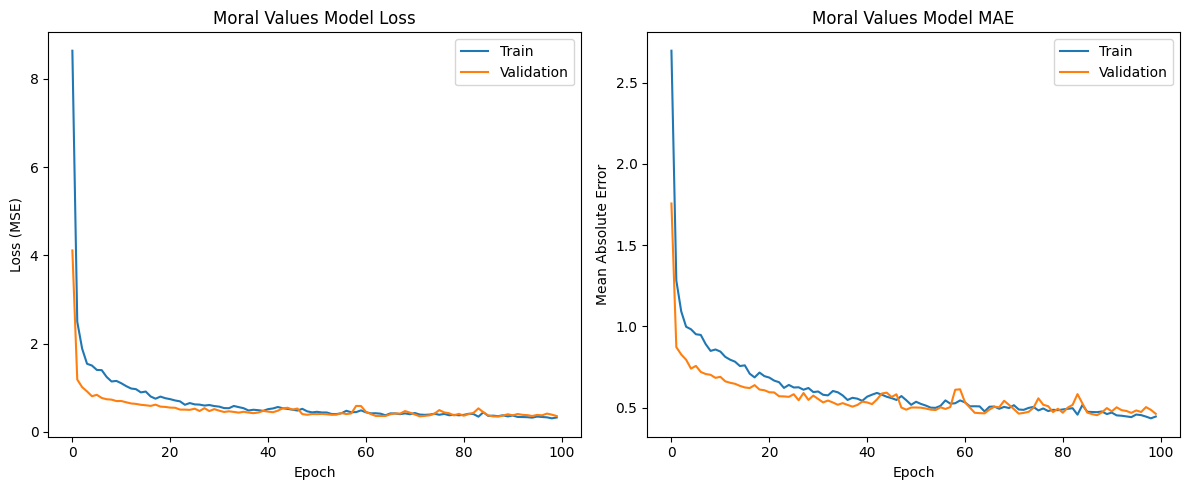

(117, 6)
(117, 6)


In [ ]:
# Cell 10: Evaluate the Model (MODIFIED for Moral Values)

# Make predictions on the test set
y_pred_mv = keras_model_mv.predict(X_test_mv)

print("Evaluation on Test Set (Moral Values):")
normalized_mses_mv = []
for i, moral_value_name in enumerate(target_cols_mv):
    mse = mean_squared_error(y_test_mv[:, i], y_pred_mv[:, i])
    r2 = r2_score(y_test_mv[:, i], y_pred_mv[:, i])
    # --- NEW: Normalized MSE (NMS) ---
    variance_target = np.var(y_test_mv[:, i])
    nmse = mse / variance_target if variance_target > 0 else float('inf') # Avoid division by zero
    normalized_mses_mv.append(nmse)
    print(f"  {moral_value_name}: MSE = {mse:.4f}, R² = {r2:.4f}, NMSE = {nmse:.4f}")

overall_mse_mv = mean_squared_error(y_test_mv, y_pred_mv)
overall_r2_mv = r2_score(y_test_mv, y_pred_mv)
print(f"\nOverall MSE (Moral Values): {overall_mse_mv:.4f}")
print(f"Overall R² (Moral Values, uniform average): {overall_r2_mv:.4f}")
print(f"Average Normalized MSE (Moral Values): {np.mean(normalized_mses_mv):.4f}")


# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mv.history['loss'])
plt.plot(history_mv.history['val_loss'])
plt.title('Moral Values Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_mv.history['mae'])
plt.plot(history_mv.history['val_mae'])
plt.title('Moral Values Model MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
print(y_pred_mv.shape)
print(y_test_mv.shape)

In [ ]:
# Cell 11: Example Prediction on a Single Instance (MODIFIED for Moral Values)

sample_index_mv = 0
sample_X_final_mv = X_test_mv[sample_index_mv:sample_index_mv+1]
sample_y_actual_mv = y_test_mv[sample_index_mv]

predicted_moral_values_example = keras_model_mv.predict(sample_X_final_mv)[0]

print("\nExample Prediction (Moral Values):")
print("---------------------------------")

print(f"Actual Moral Values for sample {sample_index_mv}:")
for i, name in enumerate(target_cols_mv):
    print(f"  {name}: {sample_y_actual_mv[i]:.2f}")

print(f"\nPredicted Moral Values for sample {sample_index_mv}:")
for i, name in enumerate(target_cols_mv):
    print(f"  {name}: {predicted_moral_values_example[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Example Prediction (Moral Values):
---------------------------------
Actual Moral Values for sample 0:
  Care: 3.33
  Equality: 2.50
  Proportionality: 3.17
  Loyalty: 1.00
  Authority: 1.50
  Purity: 1.50

Predicted Moral Values for sample 0:
  Care: 2.99
  Equality: 2.71
  Proportionality: 3.41
  Loyalty: 1.16
  Authority: 1.73
  Purity: 1.20


## Model 2: Cultursl Values

In [ ]:
# Cell 12: Data Cleaning and Preprocessing - Parsing for Cultural Values (MODIFIED)

print("--- Starting Cultural Values Model Preparation ---")

def safe_literal_eval_cell12(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        return val

# Parse Cultural_values from the 'df' that has text features processed but not yet moral value targets expanded
# (i.e., 'df' as it was at the end of text_feature_cols processing in original Cell 4)
cultural_values_parsed_cv = df['Cultural_values'].apply(safe_literal_eval_cell12)
cultural_values_df_cv = pd.json_normalize(cultural_values_parsed_cv)

cultural_value_cols_target = [
    'Power Distance', 'Individualism', 'Masculinity',
    'Uncertainty Avoidance', 'Long Term Orientation', 'Indulgence vs Restraint'
]
for col in cultural_value_cols_target:
    if col not in cultural_values_df_cv.columns:
         cultural_values_df_cv[col] = np.nan
         print(f"Warning: Cultural value column '{col}' was not found and added as NaN.")

# Create a temporary df with original index and cultural targets
df_temp_cultural_targets = pd.DataFrame(cultural_values_df_cv[cultural_value_cols_target].values,
                                        index=df.index, # Use index from the df that has all rows before moral NaN drop
                                        columns=cultural_value_cols_target)

# Now, create df_cv by taking relevant columns from df_cleaned_mv (which has NaN moral targets dropped)
# and joining the cultural targets based on the index.
# This ensures we only work with rows that were valid for the moral model's text features.
# If df_cleaned_mv has a different index than df, we need to be careful.
# Let's assume df_cleaned_mv's index corresponds to the original df's index for rows it retained.

# Select non-target columns from df_cleaned_mv (the one used for moral values embeddings)
# These are already cleaned text columns, selected_action_text, etc.
# And the original input features like 'Scenario_id', 'Annotator_id', 'Scenario', etc.
# Essentially, all columns from df_cleaned_mv *except* the moral_value_cols
base_cols_for_cv = [col for col in df_cleaned_mv.columns if col not in moral_value_cols]
df_for_cv_model = df_cleaned_mv[base_cols_for_cv].copy()

# Merge the cultural targets. This merge aligns rows based on index.
# This ensures we only consider rows that had valid moral values (used for X_embedded_features).
df_for_cv_model = df_for_cv_model.merge(df_temp_cultural_targets, left_index=True, right_index=True, how='left')


print("\nDataFrame for Cultural Values Model (df_for_cv_model) Head:")
print(df_for_cv_model[['Scenario_id', 'Selected_action_text', 'Power Distance', 'Individualism']].head())
df_for_cv_model.info()

--- Starting Cultural Values Model Preparation ---

DataFrame for Cultural Values Model (df_for_cv_model) Head:
              Scenario_id                               Selected_action_text  \
0  long_id_0_MJI_Emotions  Promote the Less Skilled but Reserved Candidat...   
1  long_id_0_MJI_Emotions  Promote the Less Skilled but Reserved Candidat...   
2  long_id_0_MJI_Emotions  Promote the Highly Qualified Candidate, potent...   
3            Reddit_id_50  Decline the invitation to avoid the uncomforta...   
4            Reddit_id_50  Attend the party to maintain the friendship an...   

   Power Distance  Individualism  
0              70              0  
1             -60            105  
2              25              0  
3             -60            105  
4             -25             70  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --

In [ ]:
# Cell 13: Prepare Final X, y for Cultural Values (MODIFIED)

target_cols_cv = cultural_value_cols_target # Defined in Cell 12

# Drop rows where any target CULTURAL value is NaN from df_for_cv_model
df_cleaned_cv_final = df_for_cv_model.dropna(subset=target_cols_cv).copy()
print(f"\nShape of df_for_cv_model before dropping NaN cultural targets: {df_for_cv_model.shape}")
print(f"Shape of df_cleaned_cv_final after dropping NaN cultural targets: {df_cleaned_cv_final.shape}")
if df_cleaned_cv_final.shape[0] < df_for_cv_model.shape[0]:
    print(f"Dropped {df_for_cv_model.shape[0] - df_cleaned_cv_final.shape[0]} rows due to NaN in target cultural values.")

# --- IMPORTANT: Align X_final_features_mv ---
# X_final_features_mv was created based on df_cleaned_mv.
# We need to select rows from X_final_features_mv that correspond to df_cleaned_cv_final.
# Since df_cleaned_cv_final was derived from df_cleaned_mv (by adding cultural cols and then dropping NaNs),
# its index should be a subset of or equal to df_cleaned_mv's index.
common_indices = df_cleaned_mv.index.intersection(df_cleaned_cv_final.index)
X_final_features_cv = X_final_features_mv[df_cleaned_mv.index.isin(common_indices)]
y_targets_raw_cv = df_cleaned_cv_final[target_cols_cv].values # Get y targets corresponding to the cleaned X

# --- NEW: Scale Cultural Value Targets ---
scaler_targets_cv = StandardScaler()
y_targets_scaled_cv = scaler_targets_cv.fit_transform(y_targets_raw_cv)

print(f"\nShape of X_final_features_cv: {X_final_features_cv.shape}")
print(f"Shape of y_targets_scaled_cv: {y_targets_scaled_cv.shape}")

print("\nChecking for NaNs in cultural target features after scaling and cleaning:")
print(pd.DataFrame(y_targets_scaled_cv, columns=target_cols_cv).isnull().sum())


Shape of df_for_cv_model before dropping NaN cultural targets: (582, 22)
Shape of df_cleaned_cv_final after dropping NaN cultural targets: (582, 22)

Shape of X_final_features_cv: (582, 2689)
Shape of y_targets_scaled_cv: (582, 6)

Checking for NaNs in cultural target features after scaling and cleaning:
Power Distance             0
Individualism              0
Masculinity                0
Uncertainty Avoidance      0
Long Term Orientation      0
Indulgence vs Restraint    0
dtype: int64


In [ ]:
# Cell 14: Split Data for Cultural Model (MODIFIED)
X_train_cv, X_test_cv, y_train_scaled_cv, y_test_scaled_cv = train_test_split(
    X_final_features_cv, y_targets_scaled_cv, test_size=0.2, random_state=42
)

print(f"X_train_cv shape: {X_train_cv.shape}, y_train_scaled_cv shape: {y_train_scaled_cv.shape}")
print(f"X_test_cv shape: {X_test_cv.shape}, y_test_scaled_cv shape: {y_test_scaled_cv.shape}")

X_train_cv shape: (465, 2689), y_train_scaled_cv shape: (465, 6)
X_test_cv shape: (117, 2689), y_test_scaled_cv shape: (117, 6)


In [ ]:
# Cell 15: Build and Compile the Cultural Values Neural Network Model (MODIFIED)

input_combined_features_cv = Input(shape=(X_train_cv.shape[1],), name='input_combined_features_cv')

# Dense layers - example of slightly different architecture for cultural model
x_cv = Dense(256, activation='relu', name='dense_1_cv')(input_combined_features_cv)
x_cv = Dropout(0.35, name='dropout_1_cv')(x_cv) # Adjusted dropout
x_cv = Dense(128, activation='relu', name='dense_2_cv')(x_cv)
x_cv = Dropout(0.35, name='dropout_2_cv')(x_cv)
x_cv = Dense(64, activation='relu', name='dense_3_cv')(x_cv) # Kept this layer

output_layer_cv = Dense(len(target_cols_cv), activation='linear', name='cultural_values_output_cv')(x_cv)

keras_model_cv = Model(inputs=input_combined_features_cv, outputs=output_layer_cv, name="cultural_values_model")

optimizer_cv = Adam(learning_rate=0.0007) # Slightly different learning rate
keras_model_cv.compile(optimizer=optimizer_cv, loss='mean_squared_error', metrics=['mae'])

keras_model_cv.summary()

Model: "cultural_values_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_combined_features_cv      │ (None, 2689)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_cv (Dense)              │ (None, 256)            │       688,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_cv (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_cv (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_cv (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3_cv (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cultural_values_output_cv       │ (None, 6)              │           390 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,182 (2.79 MB)

 Trainable params: 730,182 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 16: Train the Cultural Values Model (MODIFIED)
epochs_cv = 120 # Example: different number of epochs
batch_size_cv = 32

early_stopping_cv = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12, # Example: different patience
    restore_best_weights=True,
    verbose=1
)

history_cv = keras_model_cv.fit(
    X_train_cv, y_train_scaled_cv, # Use scaled targets for training
    epochs=epochs_cv,
    batch_size=batch_size_cv,
    validation_split=0.15,
    callbacks=[early_stopping_cv],
    verbose=1
)

print("\nCultural values model training finished.")

Epoch 1/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.9746 - mae: 0.7921 - val_loss: 0.9520 - val_mae: 0.7811
Epoch 2/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9273 - mae: 0.7719 - val_loss: 0.9134 - val_mae: 0.7640
Epoch 3/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8925 - mae: 0.7573 - val_loss: 0.8621 - val_mae: 0.7396
Epoch 4/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8150 - mae: 0.7256 - val_loss: 0.7959 - val_mae: 0.7106
Epoch 5/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7500 - mae: 0.6900 - val_loss: 0.7466 - val_mae: 0.6792
Epoch 6/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6884 - mae: 0.6647 - val_loss: 0.6696 - val_mae: 0.6373
Epoch 7/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5980 - mae: 0.6112 - val_loss: 0.6252 - val_mae: 0.6097
Epoch 8/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5232 - mae: 0.5732 - val_loss: 0.5786 - val_mae: 0.5856
Epoch 9/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Evaluation on Test Set (Cultural Values - Original Scale):
  Power Distance: MSE = 1437.1076, R² = 0.5821, NMSE = 0.4179
  Individualism: MSE = 1256.7842, R² = 0.5889, NMSE = 0.4111
  Masculinity: MSE = 1830.7658, R² = 0.5897, NMSE = 0.4103
  Uncertainty Avoidance: MSE = 2157.9708, R² = 0.7190, NMSE = 0.2810
  Long Term Orientation: MSE = 1492.9050, R² = 0.5905, NMSE = 0.4095
  Indulgence vs Restraint: MSE = 1906.2896, R² = 0.6674, NMSE = 0.3326

Overall MSE (Cultural Values - Original Scale): 1680.3038
Overall R² (Cultural Values - Original Scale, uniform average): 0.6229
Average Normalized MSE (Cultural Values): 0.3771


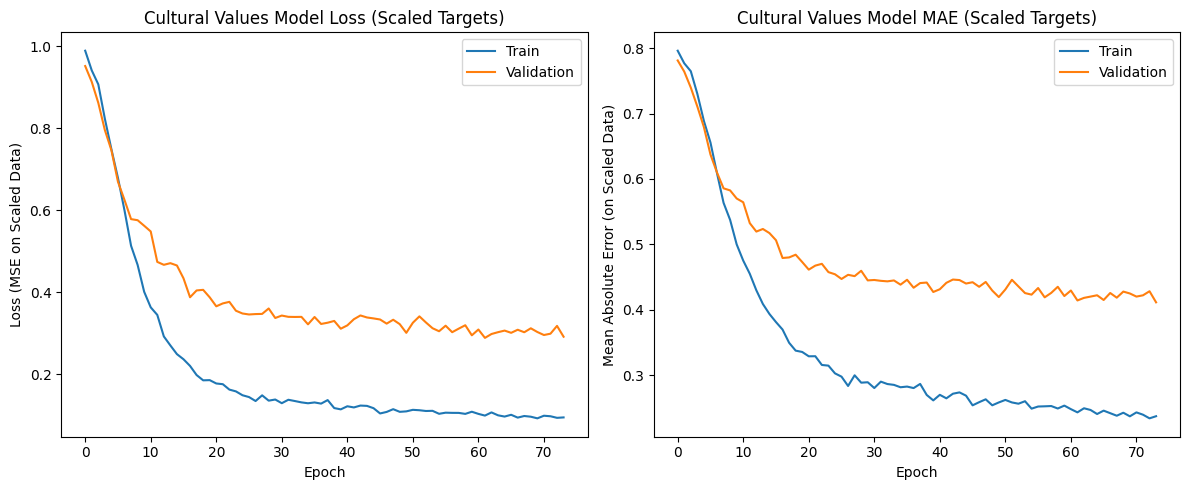

In [ ]:
# Cell 17: Evaluate the Cultural Values Model (MODIFIED)

# Make predictions (these will be on the scaled an_data)
y_pred_scaled_cv = keras_model_cv.predict(X_test_cv)

# --- NEW: Inverse transform predictions and test targets to original scale for evaluation ---
y_pred_original_scale_cv = scaler_targets_cv.inverse_transform(y_pred_scaled_cv)
y_test_original_scale_cv = scaler_targets_cv.inverse_transform(y_test_scaled_cv) # y_test_cv was actually y_test_scaled_cv

print("Evaluation on Test Set (Cultural Values - Original Scale):")
normalized_mses_cv = []
for i, cultural_value_name in enumerate(target_cols_cv):
    mse_cv = mean_squared_error(y_test_original_scale_cv[:, i], y_pred_original_scale_cv[:, i])
    r2_cv = r2_score(y_test_original_scale_cv[:, i], y_pred_original_scale_cv[:, i])
    variance_target_cv = np.var(y_test_original_scale_cv[:, i])
    nmse_cv = mse_cv / variance_target_cv if variance_target_cv > 0 else float('inf')
    normalized_mses_cv.append(nmse_cv)
    print(f"  {cultural_value_name}: MSE = {mse_cv:.4f}, R² = {r2_cv:.4f}, NMSE = {nmse_cv:.4f}")

overall_mse_cv = mean_squared_error(y_test_original_scale_cv, y_pred_original_scale_cv)
overall_r2_cv = r2_score(y_test_original_scale_cv, y_pred_original_scale_cv)
print(f"\nOverall MSE (Cultural Values - Original Scale): {overall_mse_cv:.4f}")
print(f"Overall R² (Cultural Values - Original Scale, uniform average): {overall_r2_cv:.4f}")
print(f"Average Normalized MSE (Cultural Values): {np.mean(normalized_mses_cv):.4f}")


# Plot training & validation loss/mae (these are based on scaled targets)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cv.history['loss'])
plt.plot(history_cv.history['val_loss'])
plt.title('Cultural Values Model Loss (Scaled Targets)')
plt.ylabel('Loss (MSE on Scaled Data)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_cv.history['mae'])
plt.plot(history_cv.history['val_mae'])
plt.title('Cultural Values Model MAE (Scaled Targets)')
plt.ylabel('Mean Absolute Error (on Scaled Data)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 18: Example Prediction for Cultural Values (MODIFIED)

sample_index_cv = 0
sample_X_final_cv_test = X_test_cv[sample_index_cv:sample_index_cv+1]
sample_y_scaled_actual_cv = y_test_scaled_cv[sample_index_cv] # This is the scaled actual value

# Make prediction (output is scaled)
predicted_cultural_values_scaled_example = keras_model_cv.predict(sample_X_final_cv_test)

# --- NEW: Inverse transform both actual and predicted to original scale ---
sample_y_original_actual_cv = scaler_targets_cv.inverse_transform(sample_y_scaled_actual_cv.reshape(1, -1))[0]
predicted_cultural_values_original_example = scaler_targets_cv.inverse_transform(predicted_cultural_values_scaled_example)[0]


print("\nExample Prediction (Cultural Values - Original Scale):")
print("---------------------------------------------------")

print(f"Actual Cultural Values for sample {sample_index_cv} (Original Scale):")
for i, name in enumerate(target_cols_cv):
    print(f"  {name}: {sample_y_original_actual_cv[i]:.2f}")

print(f"\nPredicted Cultural Values for sample {sample_index_cv} (Original Scale):")
for i, name in enumerate(target_cols_cv):
    print(f"  {name}: {predicted_cultural_values_original_example[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Example Prediction (Cultural Values - Original Scale):
---------------------------------------------------
Actual Cultural Values for sample 0 (Original Scale):
  Power Distance: -0.00
  Individualism: 70.00
  Masculinity: -70.00
  Uncertainty Avoidance: -180.00
  Long Term Orientation: 40.00
  Indulgence vs Restraint: 110.00

Predicted Cultural Values for sample 0 (Original Scale):
  Power Distance: 6.65
  Individualism: 45.37
  Masculinity: -32.53
  Uncertainty Avoidance: -75.95
  Long Term Orientation: 70.69
  Indulgence vs Restraint: 76.98
